In [ ]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim

In [128]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 5e-4):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.RMSprop(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self = self.to('cuda')

In [127]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.SGD(self.parameters(), lr)
        self.loss = nn.BCEWithLogitsLoss()
        self = self.to('cuda')

    def training_step(self, true_data, fake_data, steps=5):
        for step in range(steps):
            self.optim.zero_grad()
            y_true = self.layers(true_data)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())

            y_fake = self.layers(fake_data)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_true).cuda())
            
            loss = loss_true + loss_fake
            loss.backward()
            self.optim.step()
        
        return loss

In [201]:
generator_layers = [ # bez konwolucji poki co, potem sie doda batchNorm i funkcje aktywacji
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4, 2, bias=False),
    nn.ReLU()
]
generator = Generator(generator_layers, 1e-5)

discriminator_layers = [
    nn.Linear(2, 64),
    nn.LeakyReLU(0.2),
    nn.Linear(64, 32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 16),
    nn.LeakyReLU(0.2),
    nn.Linear(16, 8),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.2),
    nn.Linear(8, 4, bias=False),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.2),
    nn.Linear(4, 2, bias=False),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.2),
    nn.Linear(2, 1, bias=False),
    nn.Sigmoid()
]
discriminator = Discriminator(discriminator_layers, 1e-5) # dyskryminator bedzie musial byc ekstremalnie glupi zeby to bylo stabilne

EPOCHS = 4_000
BATCH_SIZE = 64

generator_losses, discriminator_losses, steps_history = np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS)

generator.train()
discriminator.train()

for epoch in range(EPOCHS):
    xs, ys = metropolis_hastings_probing(greisen, length=BATCH_SIZE)
    true_data = torch.FloatTensor(np.vstack([xs, ys]).T).cuda()
    
    noise = torch.randn(size=(BATCH_SIZE, 128)).cuda()
    fake_data = generator.layers(noise).detach()

    steps = int(max(1, discriminator_losses[epoch-1] / generator_losses[epoch-1] if epoch > 0 else 0))
    discriminator_loss = discriminator.training_step(true_data, fake_data, steps=steps)

    # trenowanie generatora
    generator.zero_grad()
    fake_data = generator.layers(noise)
    fake_labels = discriminator.layers(fake_data)
    generator_loss = generator.loss(fake_labels, torch.ones_like(fake_labels).cuda())
    generator_loss.backward()
    generator.optim.step()

    steps_history[epoch] = steps
    generator_losses[epoch] = generator_loss.item()
    discriminator_losses[epoch] = discriminator_loss.item()

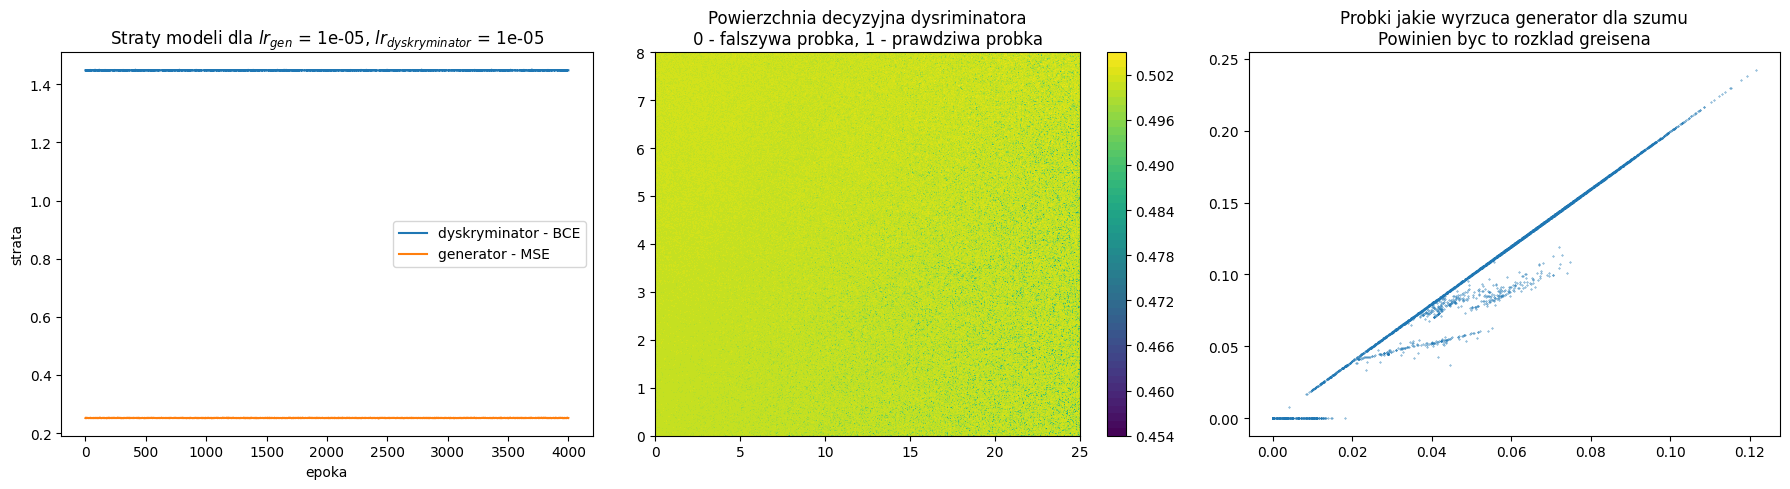

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Wykres 1: Straty
ax1.set_title(rf'Straty modeli dla $lr_{{gen}}$ = {generator.optim.param_groups[0]['lr']}, $lr_{{dyskryminator}}$ = {discriminator.optim.param_groups[0]['lr']}')
ax1.plot(discriminator_losses, label='dyskryminator - BCE')
ax1.plot(generator_losses, label='generator - MSE')
ax1.legend()
ax1.set_xlabel('epoka')
ax1.set_ylabel('strata')

# Wykres 2: Powierzchnia decyzyjna
x_range = np.linspace(0, 25, num=1_000)
y_range = np.linspace(0, 8, num=1_000)
X, Y = np.meshgrid(x_range, y_range)
mapa = torch.FloatTensor(np.column_stack([X.flatten(), Y.flatten()])).cuda()
discriminator_assessment = discriminator.layers(mapa).cpu().detach().numpy().reshape(x_range.shape[0], y_range.shape[0])
ax2.set_title('Powierzchnia decyzyjna dysriminatora\n0 - falszywa probka, 1 - prawdziwa probka')
contour = ax2.contourf(X, Y, discriminator_assessment, levels=50)
plt.colorbar(contour, ax=ax2)

# Wykres 3: Próbki generatora
noises = torch.randn(size=(100, BATCH_SIZE, 128)).cuda()
x, y = [], []
for noise in noises:
    output = generator.layers(noise).cpu().detach().numpy().reshape(-1, 2)
    x.extend(output[:, 0])
    y.extend(output[:, 1])
x = np.array(x)
y = np.array(y)
ax3.set_title('Probki jakie wyrzuca generator dla szumu\nPowinien byc to rozklad greisena')
ax3.scatter(x, y, s=0.1)

plt.tight_layout()
plt.savefig('./Wykresy/GAN/podsumowanie.jpg')

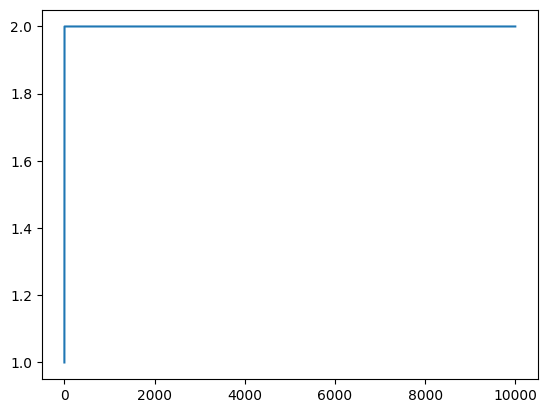

In [159]:
plt.plot(steps_history)